In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc

In [3]:
# Google colab connection
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Dataset/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/28/class-28-51.jpg  
  inflating: data/28/class-28-52.jpg  
  inflating: data/28/class-28-53.jpg  
  inflating: data/28/class-28-54.jpg  
  inflating: data/28/class-28-55.jpg  
  inflating: data/28/class-28-56.jpg  
  inflating: data/28/class-28-57.jpg  
  inflating: data/28/class-28-58.jpg  
  inflating: data/28/class-28-59.jpg  
  inflating: data/28/class-28-6.jpg  
  inflating: data/28/class-28-60.jpg  
  inflating: data/28/class-28-61.jpg  
  inflating: data/28/class-28-62.jpg  
  inflating: data/28/class-28-63.jpg  
  inflating: data/28/class-28-64.jpg  
  inflating: data/28/class-28-65.jpg  
  inflating: data/28/class-28-66.jpg  
  inflating: data/28/class-28-67.jpg  
  inflating: data/28/class-28-68.jpg  
  inflating: data/28/class-28-69.jpg  
  inflating: data/28/class-28-7.jpg  
  inflating: data/28/class-28-70.jpg  
  inflating: data/28/class-28-71.jpg  
  inflating: data/28/class-28-72.jpg  
  inflating: da

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory paths
data_dir = '/content/data'
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator instances for train, validation, and test sets with augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into 80% train and 20% validation
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# For the test set, you might need a separate directory or split
test_generator = test_datagen.flow_from_directory(
    '/content/data',  # If you have a separate test dataset
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9504 images belonging to 38 classes.
Found 2360 images belonging to 38 classes.
Found 11864 images belonging to 38 classes.


In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the ResNet50 model pre-trained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(38, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 2s 0us/step


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Train the model
history = model.fit(
    train_generator,
    epochs=50 ,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/50
297/297 [==============================] - 309s 713ms/step - loss: 3.4660 - accuracy: 0.1052 - val_loss: 2.8839 - val_accuracy: 0.2915 - lr: 1.0000e-05
Epoch 2/50
297/297 [==============================] - 207s 695ms/step - loss: 2.1417 - accuracy: 0.4513 - val_loss: 1.2960 - val_accuracy: 0.6564 - lr: 1.0000e-05
Epoch 3/50
297/297 [==============================] - 212s 714ms/step - loss: 1.0122 - accuracy: 0.7184 - val_loss: 0.8057 - val_accuracy: 0.7568 - lr: 1.0000e-05
Epoch 4/50
297/297 [==============================] - 204s 686ms/step - loss: 0.6235 - accuracy: 0.8198 - val_loss: 0.6224 - val_accuracy: 0.8055 - lr: 1.0000e-05
Epoch 5/50
297/297 [==============================] - 204s 686ms/step - loss: 0.4514 - accuracy: 0.8722 - val_loss: 0.5430 - val_accuracy: 0.8335 - lr: 1.0000e-05
Epoch 6/50
297/297 [==============================] - 211s 711ms/step - loss: 0.3416 - accuracy: 0.9051 - val_loss: 0.5325 - val_accuracy: 0.8394 - lr: 1.0000e-05
Epoch 7/50
297/297 [==

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')


371/371 [==============================] - 63s 169ms/step - loss: 0.1437 - accuracy: 0.9593
Test accuracy: 95.93%


In [ ]:
# Recheck Data Generators
test_generator = test_datagen.flow_from_directory(
    '/content/data',  # Make sure this directory is correct
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure no shuffling for consistency in predictions
)

# 1. Evaluate model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy from evaluate: {test_acc * 100:.2f}%')

371/371 [==============================] - 60s 161ms/step
Accuracy: 0.9592886041807148


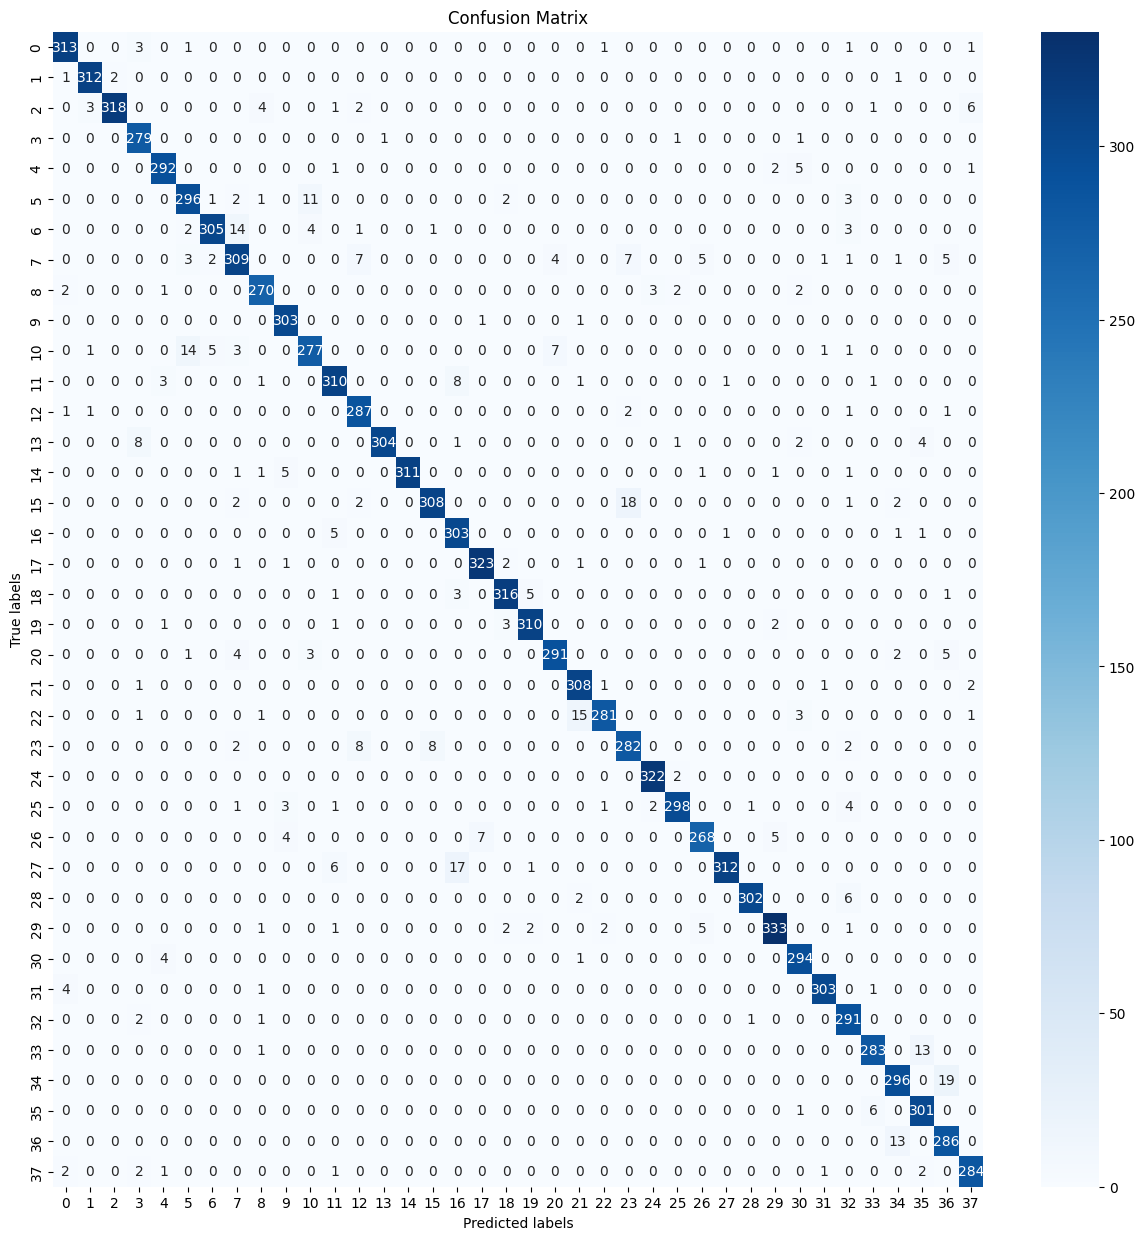

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       320
           1       0.98      0.99      0.99       316
           2       0.99      0.95      0.97       335
           3       0.94      0.99      0.97       282
           4       0.97      0.97      0.97       301
           5       0.93      0.94      0.94       316
           6       0.97      0.92      0.95       330
           7       0.91      0.90      0.90       345
           8       0.96      0.96      0.96       280
           9       0.96      0.99      0.98       305
          10       0.94      0.90      0.92       309
          11       0.95      0.95      0.95       325
          12       0.93      0.98      0.96       293
          13       1.00      0.95      0.97       320
          14       1.00      0.97      0.98       321
          15       0.97      0.92      0.95       333
          16       0.91      0.97      0.94       311
    

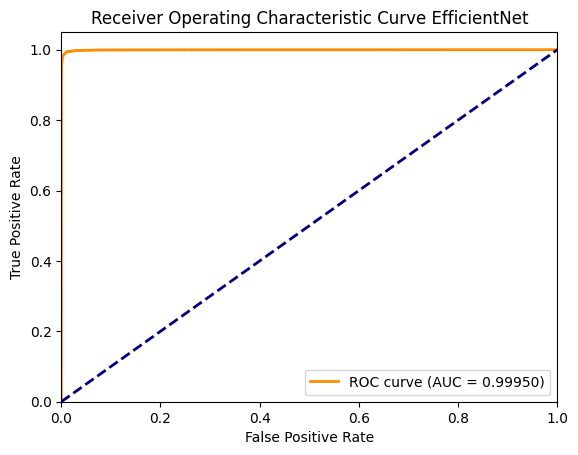

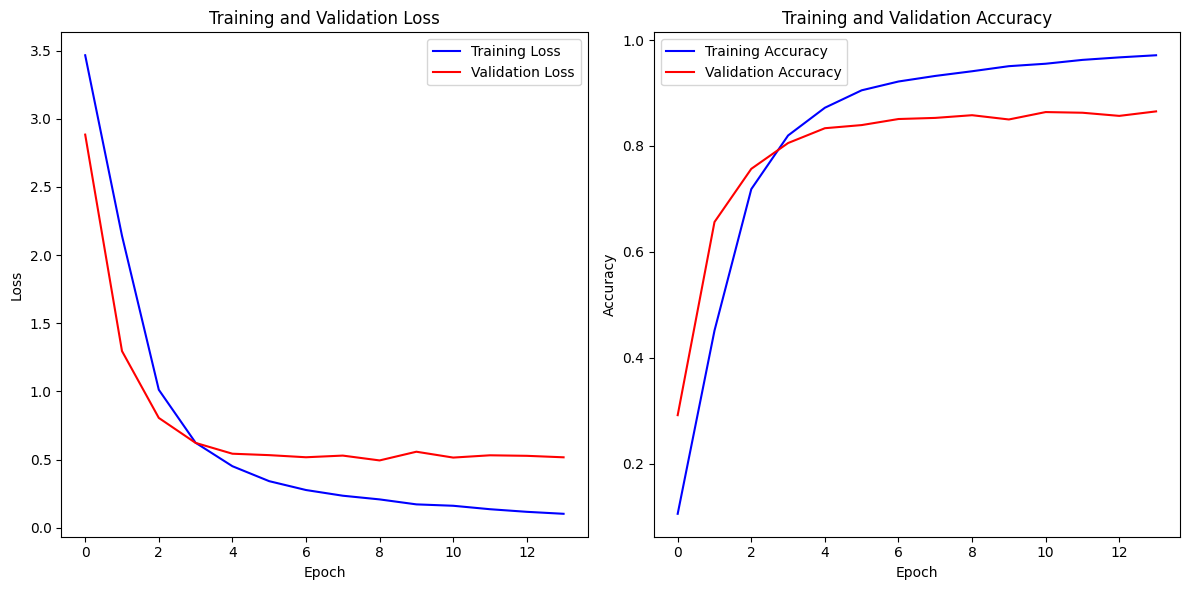

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score

# Evaluate the model on test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve EfficientNet')
plt.legend(loc="lower right")
plt.show()

# Plot loss and accuracy per epoch
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()